<a href="https://colab.research.google.com/github/vb153/computer-vision-bootcamp/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
"""
UWARG CIFAR-10 Bootcamp - Vivek Bhardwaj (v24bhard@uwaterloo.ca)
IPYNB Link: https://colab.research.google.com/drive/1x3YRaA5zAQ2nncSo4KaBsVQ0ZbtqEbwo?usp=sharing

UWARG Computer Vision Bootcamp:
* Notes:
* TensorFlow Keras has the CIFAR-10 dataset as a module, so you don't need to manually download and unpack it.
"""

# Import Modules
import keras
import numpy as np
import tensorflow as tf

# Import Libraries and Datasets
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10

# Defined Constants
IMAGE_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 10

# Data Pre-processing


In [ ]:
def data_preprocess():
  """
  Load and preprocess cifar10 dataset into train and test data

  Returns
  -------
  trainImgs, trainLabels, testImgs, testLabels
    returns 4 numpy arrays containing X and Y train/test data
  """
  (trainX, trainY), (testX, testY) = cifar10.load_data()

  # rescale pixel values [0, 1]
  trainX = trainX.astype('float32')/255.0
  testX = testX.astype('float32')/255.0

  # categorize data based on binary values
  testY = tf.keras.utils.to_categorical(testY)
  trainY = tf.keras.utils.to_categorical(trainY)

  return trainX, trainY, testX, testY

# CNN Sequential Model

In [ ]:
def cnn_model():
  """
  Create a 3-Layer Convolutional Neural Network for Classification

  Returns
  -------
  cnn: tf.keras.Sequential()
  """
  # CNN Model
  cnn = models.Sequential() 

  # Input Layer
  cnn.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
  cnn.add(layers.MaxPool2D((2,2)))
  cnn.add(layers.Dropout(0.2))

  # 2nd Layer
  cnn.add(layers.Conv2D(128, (3,3), activation = 'relu'))
  cnn.add(layers.MaxPool2D((2,2)))
  cnn.add(layers.Dropout(0.2))

  # Flatten to move tensors to dense layers
  cnn.add(layers.Flatten())
  
  # 3rd Layer
  cnn.add(layers.Dense(512, activation = 'relu'))

  # Output Layer
  cnn.add(layers.Dense(10, activation = 'softmax'))

  # Compiler CNN
  cnn.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  
  return cnn

# Plotting

In [ ]:
def loss_plot(history):
  """
  Plot loss using matplotlib

  Params
  ------
  Required: history - kerals.callbackcs.History

  Returns
  -------
  matplotlib.pylot
  """
  
  # Loss plot
  plt.clf()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc="upper left")
  plt.show()

# Model Testing

In [ ]:
def main():
  """
  Testing Model
  """

  trainX, trainY, testX, testY = data_preprocess()
  model = cnn_model()

  # fit data
  history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(testX, testY))

  loss_plot(history)

# Results

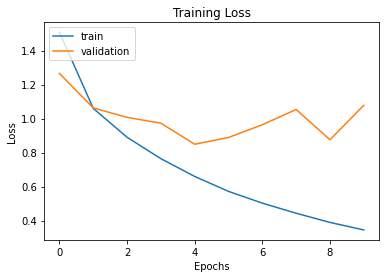



In [ ]:
"""

Epoch 1/10
782/782 [==============================] - 179s 228ms/step - loss: 1.5077 - accuracy: 0.4621 - val_loss: 1.2656 - val_accuracy: 0.5604
Epoch 2/10
782/782 [==============================] - 179s 229ms/step - loss: 1.0601 - accuracy: 0.6279 - val_loss: 1.0629 - val_accuracy: 0.6286
Epoch 3/10
782/782 [==============================] - 175s 224ms/step - loss: 0.8902 - accuracy: 0.6923 - val_loss: 1.0071 - val_accuracy: 0.6550
Epoch 4/10
782/782 [==============================] - 166s 212ms/step - loss: 0.7643 - accuracy: 0.7375 - val_loss: 0.9730 - val_accuracy: 0.6636
Epoch 5/10
782/782 [==============================] - 166s 212ms/step - loss: 0.6598 - accuracy: 0.7725 - val_loss: 0.8492 - val_accuracy: 0.7169
Epoch 6/10
782/782 [==============================] - 166s 213ms/step - loss: 0.5720 - accuracy: 0.8039 - val_loss: 0.8888 - val_accuracy: 0.7072
Epoch 7/10
782/782 [==============================] - 166s 212ms/step - loss: 0.5029 - accuracy: 0.8290 - val_loss: 0.9640 - val_accuracy: 0.6996
Epoch 8/10
782/782 [==============================] - 166s 212ms/step - loss: 0.4436 - accuracy: 0.8512 - val_loss: 1.0534 - val_accuracy: 0.7115
Epoch 9/10
782/782 [==============================] - 166s 213ms/step - loss: 0.3894 - accuracy: 0.8682 - val_loss: 0.8755 - val_accuracy: 0.7367
Epoch 10/10
782/782 [==============================] - 167s 213ms/step - loss: 0.3454 - accuracy: 0.8836 - val_loss: 1.0782 - val_accuracy: 0.7148

"""